# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go
#offline.init_notebook_mode()
#from collections import Counter

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [2]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)

for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

compound: 0.9975, pos: 0.245, neu: 0.745, neg: 0.01, 

### Sentiment Analysis features

<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [3]:
import pandas
data = pandas.read_csv('preprocessed_data.csv')

In [4]:
y = data["project_is_approved"].values
X = data.drop(["project_is_approved"],axis=1)

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [5]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)


In [6]:
senti_dict  = dict(X_train["essay"].apply(sid.polarity_scores)) # making a dictionary of all the features
senti_dict_test = dict(X_test["essay"].apply(sid.polarity_scores))
senti_array_train = np.array(pd.DataFrame.from_dict(senti_dict).T) # converting the dictionary into array 
senti_array_test = np.array(pd.DataFrame.from_dict(senti_dict_test).T)

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [0]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label


## TFIDF

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

idf_vectorizer = TfidfVectorizer(ngram_range=(1,4),min_df=10,max_features=5000)
idf_vectorizer.fit(X_train["essay"].values)

X_train_essay_tfidf = idf_vectorizer.transform(X_train["essay"].values)
X_test_essay_tfidf = idf_vectorizer.transform(X_test["essay"].values)

print("After vectorizer")
print(X_train_essay_tfidf.shape,y_train.shape)

print(X_test_essay_tfidf.shape,y_test.shape)


(73196, 8) (73196,)
(36052, 8) (36052,)


### TF-IDF W2v

In [111]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [112]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train["essay"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [113]:
# compute average word2vec for each review.
train_tfidf_w2v_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_essays.append(vector)

print(len(train_tfidf_w2v_essays))
print(len(train_tfidf_w2v_essays[0]))

100%|██████████| 73196/73196 [02:42<00:00, 451.75it/s]

73196
300


In [114]:
test_tfidf_w2v_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_essays.append(vector)

print(len(test_tfidf_w2v_essays))
print(len(test_tfidf_w2v_essays[0]))

100%|██████████| 36052/36052 [01:17<00:00, 464.67it/s]

36052
300


In [115]:
train_tfidf_w2v_essays_arr = np.array(train_tfidf_w2v_essays)
test_tfidf_w2v_essays_arr = np.array(test_tfidf_w2v_essays)

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [0]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

### Categorical Features : Response Coding 

In [7]:
col_list  =['school_state', 'teacher_prefix', 'project_grade_category', 'clean_categories','clean_subcategories']
def response_fit(X_tr,y_tr,col):
   
    col_0_dict = dict(X_tr[y_tr== 0].groupby(col).size() / X_tr.groupby(col).size())
    col_1_dict = dict(X_tr[y_tr == 1].groupby(col).size() / X_tr.groupby(col).size())
    
    return col_0_dict,col_1_dict

def response_transform(data,col,dict_0,dict_1):
    col_0 = data[col].map(dict_0).fillna(0.5)
    col_1 = data[col].map(dict_1).fillna(0.5)
    
    return col_0,col_1


def transform_feat(data):
        cat_feature = pd.DataFrame()
        for i in col_list : 
            dict_0,dict_1 = response_fit(X_train,y_train,i) # Fitting is always on train data 
            cat_feature[i+"_0"],cat_feature[i+"_1"]= response_transform(data,i,dict_0,dict_1)
        return cat_feature



In [8]:
X_train_catf = np.array(transform_feat(X_train))
X_test_catf = np.array(transform_feat(X_test))

### Numerical features

In [9]:
from sklearn.preprocessing import Normalizer

In [13]:
def norm(train,test,col):
    normalizer = Normalizer()
    normalizer.fit(X_train[col].values.reshape(1,-1))
    X_train_col_norm = normalizer.transform(X_train[col].values.reshape(1,-1))
    X_test_col_norm = normalizer.transform(X_test[col].values.reshape(1,-1))

    return X_train_col_norm.reshape(-1,1),X_test_col_norm.reshape(-1,1)



In [14]:
X_train_price_norm,X_test_price_norm = norm(X_train,X_test,"price")
#teacher_number_of_previously_posted_projects
X_train_pp_norm,X_test_pp_norm = norm(X_train,X_test,"teacher_number_of_previously_posted_projects")

# Merging all the features 

In [11]:
#import scipy.sparse
#train_tfidf=scipy.sparse.load_npz('train_tfidf.npz')
#test_tfidf = scipy.sparse.load_npz('test_tfidf.npz')

#test_w2v = scipy.sparse.load_npz('test_w2v_tidf.npz')
#train_w2v = scipy.sparse.load_npz('train_w2v_tfidf.npz')

### Merging the Data 

In [15]:
# Tfidf
X_tr_2 = hstack((train_tfidf,X_train_catf,X_train_price_norm,X_train_pp_norm,senti_array_train)).tocsr()
X_te_2 = hstack((test_tfidf,X_test_catf,X_test_price_norm,X_test_pp_norm,senti_array_test)).tocsr()


# W2v
X_tr_w2v = hstack((train_w2v,X_train_catf,X_train_price_norm,X_train_pp_norm)).tocsr()
X_te_w2v = hstack((test_w2v,X_test_catf,X_test_price_norm,X_test_pp_norm)).tocsr()

<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [0]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [16]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [17]:
x_cfl=XGBClassifier()

prams={
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    
}
random_cfl_1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,return_train_score = True)
random_cfl_1.fit(X_tr_2,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:  8.3min remaining:  8.3min
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed: 10.1min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed: 11.3min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed: 11.6min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 12.9min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=Non...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                    

In [18]:
with open('clf1_xgb.pkl', 'wb') as f:
     pickle.dump(random_cfl_1, f)



In [19]:
pd.DataFrame(random_cfl_1.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,360.281201,1.694800,0.846549,0.858896,1,5,"{'max_depth': 5, 'colsample_bytree': 1}",7,0.846516,0.858324,...,0.846301,0.858394,0.847052,0.859077,0.846847,0.858565,1.235285,0.039158,0.000368,0.000666
1,690.855871,0.969029,0.842505,0.923695,1,10,"{'max_depth': 10, 'colsample_bytree': 1}",10,0.841940,0.921050,...,0.842476,0.922076,0.843500,0.924416,0.841997,0.926431,3.169599,0.060849,0.000562,0.001912
2,81.333813,1.587256,0.848352,0.850070,0.3,3,"{'max_depth': 3, 'colsample_bytree': 0.3}",2,0.848634,0.850126,...,0.848282,0.850078,0.848214,0.849907,0.848624,0.849958,0.147797,0.023158,0.000243,0.000132
3,363.863707,1.825019,0.843311,0.918455,0.5,10,"{'max_depth': 10, 'colsample_bytree': 0.5}",8,0.843443,0.922467,...,0.842544,0.918148,0.844047,0.913315,0.842612,0.917687,3.528259,0.047414,0.000632,0.003100
4,36.263383,1.651829,0.848462,0.849609,0.1,3,"{'max_depth': 3, 'colsample_bytree': 0.1}",1,0.848361,0.849512,...,0.848692,0.849634,0.848487,0.849565,0.848419,0.849514,0.407990,0.044430,0.000125,0.000115
5,118.774523,1.618859,0.847915,0.850234,0.5,3,"{'max_depth': 3, 'colsample_bytree': 0.5}",3,0.848156,0.850195,...,0.847804,0.850180,0.848145,0.850231,0.848145,0.849856,0.173485,0.037235,0.000324,0.000273
6,221.953726,1.663517,0.842888,0.911109,0.3,10,"{'max_depth': 10, 'colsample_bytree': 0.3}",9,0.842213,0.911145,...,0.842681,0.910839,0.842339,0.913196,0.844388,0.908329,2.474825,0.216940,0.000782,0.001613
7,49.391024,1.683553,0.847478,0.854582,0.1,5,"{'max_depth': 5, 'colsample_bytree': 0.1}",4,0.847336,0.854703,...,0.847326,0.854689,0.847462,0.854774,0.847804,0.853835,0.100732,0.005076,0.000173,0.000382
8,117.534798,1.579118,0.847218,0.856717,0.3,5,"{'max_depth': 5, 'colsample_bytree': 0.3}",5,0.847541,0.856343,...,0.847804,0.856652,0.846847,0.856943,0.847121,0.856789,0.418608,0.078366,0.000397,0.000210
9,137.674672,0.812694,0.846795,0.857721,0.5,5,"{'max_depth': 5, 'colsample_bytree': 0.5}",6,0.847336,0.857555,...,0.846096,0.858104,0.847121,0.857506,0.846847,0.858070,13.046673,0.013686,0.000433,0.000305


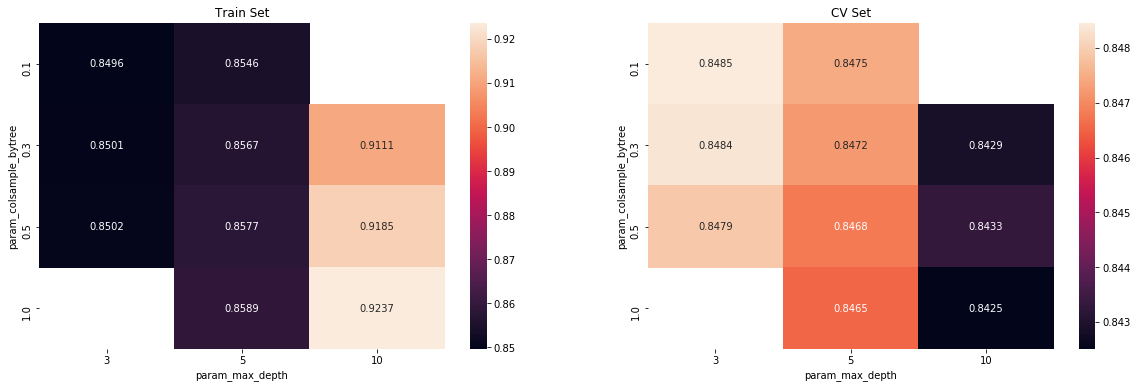

In [20]:
import seaborn as sns 
max_scores1 = pd.DataFrame(random_cfl_1.cv_results_).groupby(['param_colsample_bytree', 'param_max_depth']).max().unstack()[['mean_train_score','mean_test_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [22]:
colsample_bytree = random_cfl_1.best_params_['colsample_bytree']
max_depth= random_cfl_1.best_params_['max_depth']
est_1= XGBClassifier(colsample_bytree = colsample_bytree,max_depth= max_depth )
est_1.fit(X_tr_2,y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [23]:
with open('est1_xgb.pkl', 'wb') as f:
     pickle.dump(est_1, f)

In [24]:
#Prediction
y_train_pred_tfidf = est_1.predict(X_tr_2)
y_test_pred_tfidf = est_1.predict(X_te_2)
#Predicted Probability
y_train_pred_tfidf_pp= est_1.predict_proba(X_tr_2)[:,1]
y_test_pred_tfidf_pp = est_1.predict_proba(X_te_2)[:,1]

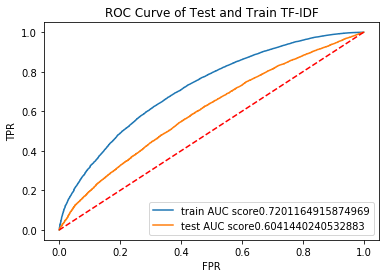

In [38]:
from sklearn.metrics import roc_curve,auc
fpr_tr,tpr_tr,__tr = roc_curve(y_train,y_train_pred_tfidf_pp)
fpr_te,tpr_te,__te = roc_curve(y_test,y_test_pred_tfidf_pp)
tfidf_test_auc = auc(fpr_te,tpr_te)

plt.title("ROC Curve of Test and Train TF-IDF" )
plt.plot(fpr_tr,tpr_tr,label = "train AUC score" + str(auc(fpr_tr,tpr_tr)))
plt.plot(fpr_te,tpr_te,label = "test AUC score"+ str(auc(fpr_te,tpr_te)))
plt.legend()
plt.plot([1,0],[1,0],"r--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

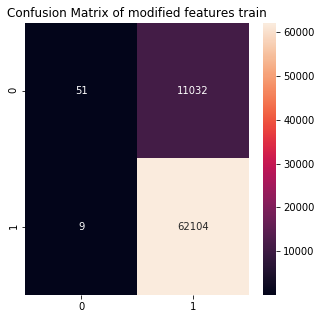

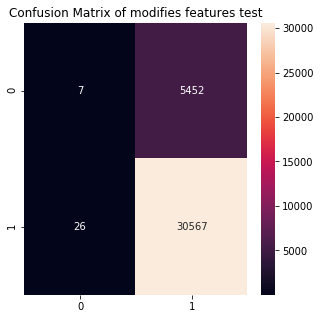

In [44]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_train,y_train_pred_tfidf)
df_cm = pd.DataFrame(array, range(2), range(2))
plt.figure(figsize=(5,5))
plt.title("Confusion Matrix of modified features train")
sns.heatmap(df_cm,annot =True,fmt = "g") # font size

plt.show()


array = confusion_matrix(y_test,y_test_pred_tfidf)
df_cm = pd.DataFrame(array, range(2), range(2))
plt.figure(figsize=(5,5))
plt.title("Confusion Matrix of modifies features test")
sns.heatmap(df_cm,annot =True,fmt = "g") # font size

plt.show()

### W2V- GBDT

In [26]:
x_cfl=XGBClassifier()

prams={
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    
}
random_cfl_2=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,return_train_score = True)
random_cfl_2.fit(X_tr_w2v,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:  9.9min remaining:  9.9min
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed: 12.3min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed: 14.4min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed: 16.0min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 17.5min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=Non...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                    

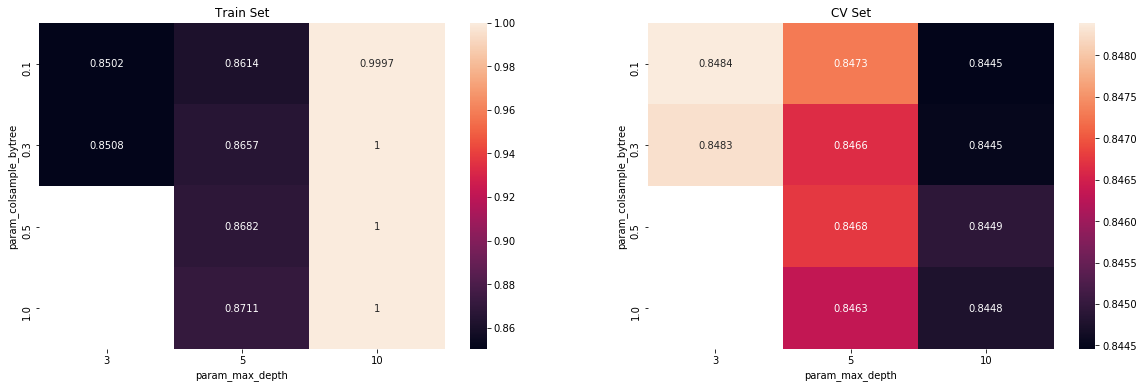

In [28]:
import seaborn as sns 
max_scores1 = pd.DataFrame(random_cfl_2.cv_results_).groupby(["param_colsample_bytree","param_max_depth"]).max().unstack()[['mean_train_score','mean_test_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [29]:
colsample_bytree = random_cfl_2.best_params_['colsample_bytree']
max_depth= random_cfl_2.best_params_['max_depth']
est_2= XGBClassifier(colsample_bytree = colsample_bytree,max_depth= max_depth )
est_2.fit(X_tr_w2v,y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [30]:
#Prediction
y_train_pred_w2v = est_2.predict(X_tr_w2v)
y_test_pred_w2v = est_2.predict(X_te_w2v)
#Predicted Probability
y_train_pred_w2v_pp= est_2.predict_proba(X_tr_w2v)[:,1]
y_test_pred_w2v_pp = est_2.predict_proba(X_te_w2v)[:,1]

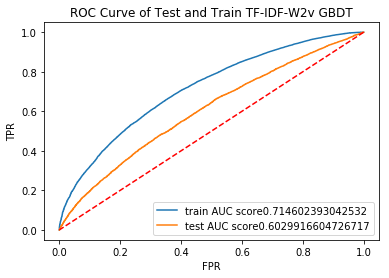

In [31]:
from sklearn.metrics import roc_curve,auc
fpr_tr,tpr_tr,__tr = roc_curve(y_train,y_train_pred_w2v_pp)
fpr_te,tpr_te,__te = roc_curve(y_test,y_test_pred_w2v_pp)
w2v_score= auc(fpr_te,tpr_te)

plt.title("ROC Curve of Test and Train TF-IDF-W2v GBDT" )
plt.plot(fpr_tr,tpr_tr,label = "train AUC score" + str(auc(fpr_tr,tpr_tr)))
plt.plot(fpr_te,tpr_te,label = "test AUC score"+ str(auc(fpr_te,tpr_te)))
plt.legend()
plt.plot([1,0],[1,0],"r--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

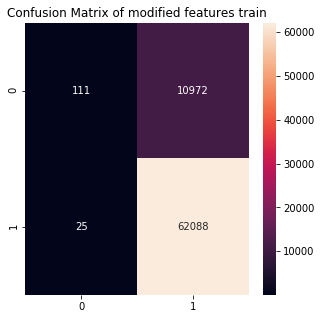

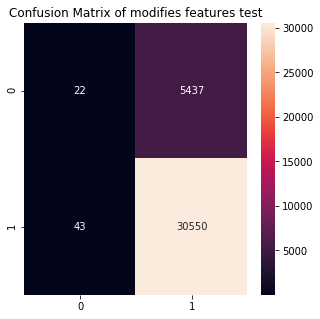

In [43]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_train,y_train_pred_w2v)
df_cm = pd.DataFrame(array, range(2), range(2))
plt.figure(figsize=(5,5))
plt.title("Confusion Matrix of modified features train")
sns.heatmap(df_cm,annot =True,fmt = "g") # font size

plt.show()


array = confusion_matrix(y_test,y_test_pred_w2v)
df_cm = pd.DataFrame(array, range(2), range(2))
plt.figure(figsize=(5,5))
plt.title("Confusion Matrix of modifies features test")
sns.heatmap(df_cm,annot =True,fmt = "g") # font size

plt.show()

In [40]:
from prettytable import PrettyTable



pt = PrettyTable()
pt.field_names = ["Vectorizer", "Model", "Parameters", "Test-AUC"]

pt.add_row(["TFIDF +Response coding+sentiment_score", "XGboost","max_depth :"+str(est_1.max_depth) + " ,colsample_bytree: " + str(est_1.colsample_bytree) ,tfidf_test_auc])
pt.add_row(["TFIDF W2V+Response coding", "XGboost","max_depth :"+str(est_2.max_depth) + " ,colsample_bytree :" + str(est_2.colsample_bytree), w2v_score])
print(pt)

+----------------------------------------+---------+-------------------------------------+--------------------+
|               Vectorizer               |  Model  |              Parameters             |      Test-AUC      |
+----------------------------------------+---------+-------------------------------------+--------------------+
| TFIDF +Response coding+sentiment_score | XGboost | max_depth :3 ,colsample_bytree: 0.1 | 0.6041440240532883 |
|       TFIDF W2V+Response coding        | XGboost | max_depth :3 ,colsample_bytree :0.1 | 0.6029916604726717 |
+----------------------------------------+---------+-------------------------------------+--------------------+
